<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week6/template_gan_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating CryptoPunks with Wasserstein GAN

Hi! In this lab, we will learn how to generate CryptoPunks using Wasserstein GAN. We will cover everything from creating and preprocessing a dataset to building and training a model, so let's get started!

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to create a custom image dataset
- How to preprocess and load four-channel images
- How to build a Deep Convolutional GAN model
- How to train GAN using earth mover's distance.

# 0 - Download data

In [ ]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/6_generative_models/gan_basics/template.zip')
!unzip -q template.zip

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=be989b8758b89468c2f175d581c850cfc01704899cba92ac9a9d44a6ecb0a8f7
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# 1 - Import packages

In [ ]:
import os, shutil
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

## Config

We will use a standard notation for the variables in GANs:
* `nz` - number of latent dimensions
* `nc` - number of channels in the final output
* `ngf` - number of feature maps carried through the generator
* `ndf` - number of feature maps carried through the discrimnator

If `earthmover_loss` is set to True, we will use earthmover distance as our loss; otherwise, we will use the regular GAN loss.

In [ ]:
# VALIDATION_FIELD[cls] Config

class Config:
    # data
    num_workers = 2
    norm_mean = (0.5, 0.5, 0.5, 0.5)
    norm_std = (0.5, 0.5, 0.5, 0.5)
    crop_size = 24
    batch_size = 64
    logdir = './logs'
    data_dir = './cryptopunk_data'

    # model
    nc = 4
    nz = 100
    ngf = 32
    ndf = 64

    # training
    seed = 21
    save_every = 5
    train_D_steps = 4
    learning_rate = 0.00005
    clip_value = 0.01
    epochs = 200
    earthmover_loss = True
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# 2 - Data exploration and preprocessing

For this lab, we will use [Cryptopunks NFT dataset](https://github.com/cryptopunksnotdead/awesome-cryptopunks-bubble), which contains 10 000 original cryptopunks in one `punks.png` image.


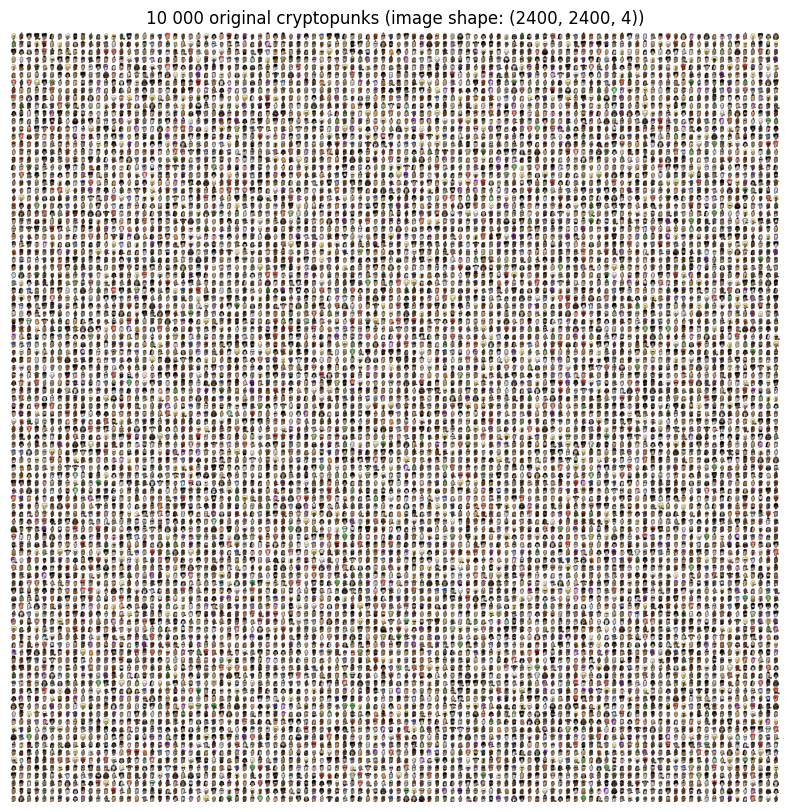

In [ ]:
# load image
img = Image.open('punks.png')
np_img = np.asarray(img)

# show function
def show(array, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(array)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

show(np_img, title=f'10 000 original cryptopunks (image shape: {np_img.shape})')

Each cryptopunk is a 24x24x4 image. The 4th channel is an alpha channel that controls the transparency of the image. The value of `0` corresponds to full transparency, and a value of `255` represents a fully opaque pixel.

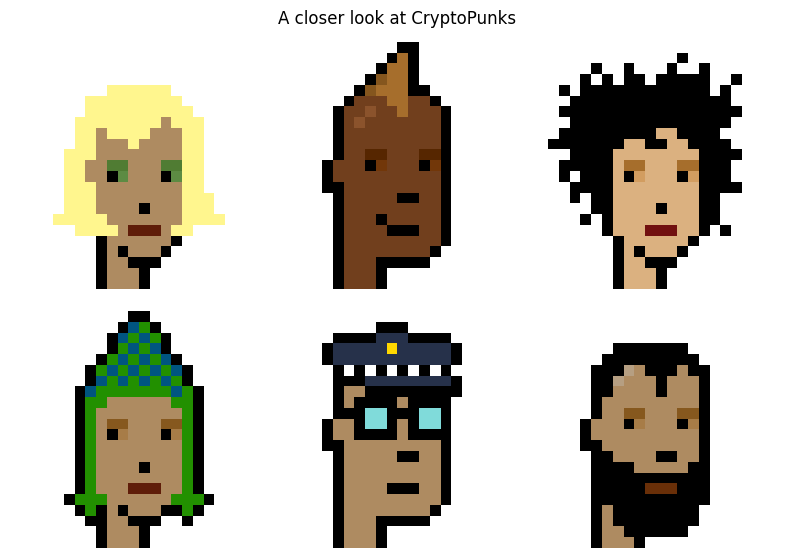

In [ ]:
show(np_img[0:48, 0:72], title='A closer look at CryptoPunks')

## Crop big image into 24x24 pixels

Let's crop the original image into 24x24 squares and save crops as separate image files.

**Excercise:** Implement the `crop` function that crops the original image array into smaller arrays of shape `[crop_size, crop_size, 4]`, where 4 is a number of channels in the original image. If the original image is not divisible by the `crop_size`, the function should return only the fully sized crops starting from the upper left corner.

In [ ]:
# VALIDATION_FIELD[func] crop

def crop(img, crop_size):
    '''
    Crops the original image into a list of crops with a size crop_size x cropz_size

    Arguments:
    img -- np.array of shape [height, width, 4]
    crop_size -- int, desired crop size

    Return:
    crops -- list of np.arrays of shape [crop_size, crop_size, 4] each
    '''
    ### START CODE HERE ### (4 lines of code)
    crops = []

    # for y in range(0, img.shape[0], crop_size):
    #   for x in range(0, img.shape[1], crop_size):
    #     # Check if crop goes within image boundaries
    #     if (y + crop_size <= img.shape[0]) and (x + crop_size <= img.shape[1]):
    #       crop_img = img[y:y + crop_size, x:x + crop_size]
    #       crops.append(crop_img)
    # print(img)
    # print(img.shape)
    # for i in range(0, img.shape[0]):
    #   crops.append(list(img[i][:len(img[i])-len(img[i])%crop_size]))

    # print(type(crops))
    # for i in range(0, len(crops), crop_size):
    #   for j in range(0, len(crops), crop_size):
    #     print(crops[i:i+crop_size][j:j+crop_size])
    #     #print(crop_img)

    #print(img.shape)
    img_limit = img.shape[1]%crop_size
    img = img[:, :img.shape[1] - img_limit]

    #print(img)
    for h in range(0, img.shape[0], crop_size):
      for w in range(0, img.shape[1], crop_size):
        crops.append(img[h:h+crop_size, w: w+crop_size])
        #print(img)
    ### END CODE HERE ###
    return crops

In [ ]:
test_img = np.arange(48).reshape(6, 8)
for i, c in enumerate(crop(test_img, 3)):
    print(f'Crop #{i+1}')
    print(c)

Crop #1
[[ 0  1  2]
 [ 8  9 10]
 [16 17 18]]
Crop #2
[[ 3  4  5]
 [11 12 13]
 [19 20 21]]
Crop #3
[[24 25 26]
 [32 33 34]
 [40 41 42]]
Crop #4
[[27 28 29]
 [35 36 37]
 [43 44 45]]


**Expected output:**
<table>
    <tr>
        <td><b>Crop #1</b></td>
        <td>
            [[ 0  1  2]<br>
             [ 8  9 10]<br>
             [16 17 18]]
        </td>
        <td><b>Crop #2</b></td>
        <td>
            [[ 3  4  5]<br>
             [11 12 13]<br>
             [19 20 21]]
        </td>
        <td><b>Crop #3</b></td>
        <td>
            [[24 25 26]<br>
             [32 33 34]<br>
             [40 41 42]]
        </td>
        <td><b>Crop #4</b></td>
        <td>
            [[27 28 29]<br>
             [35 36 37]<br>
             [43 44 45]]
        </td>
    </tr>
</table>

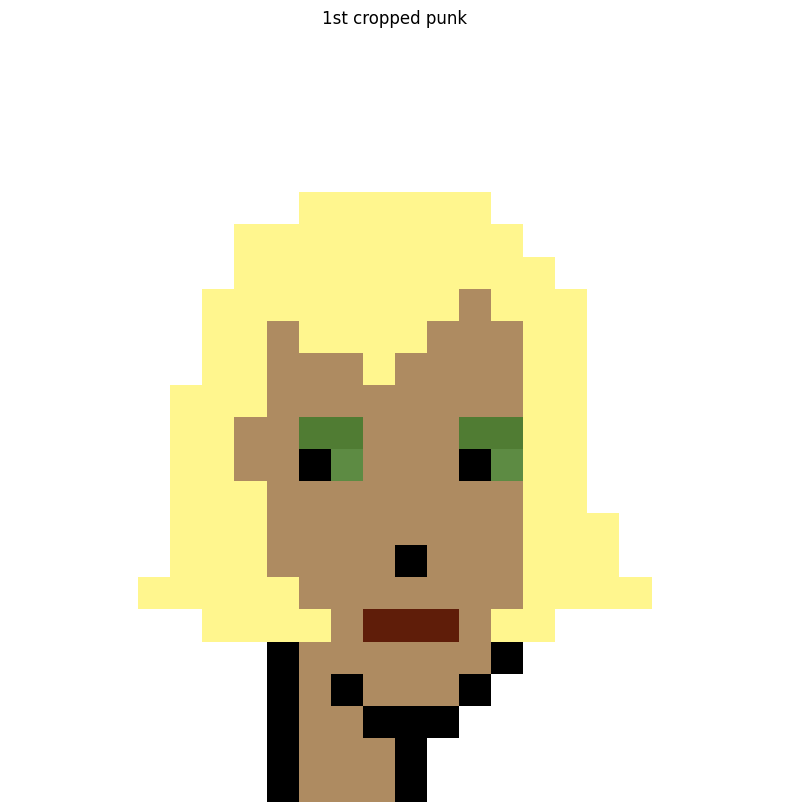

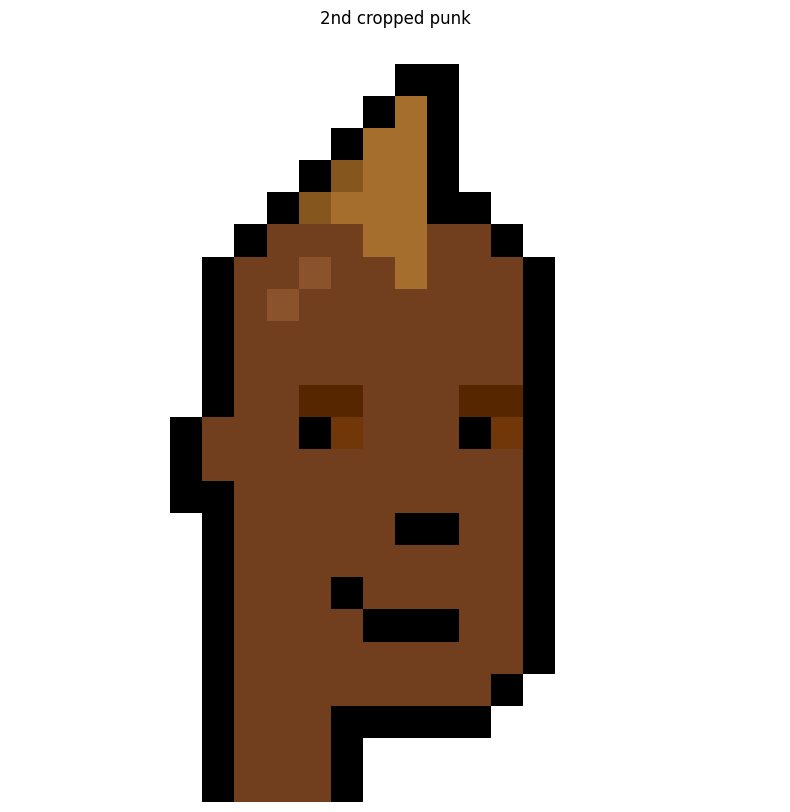

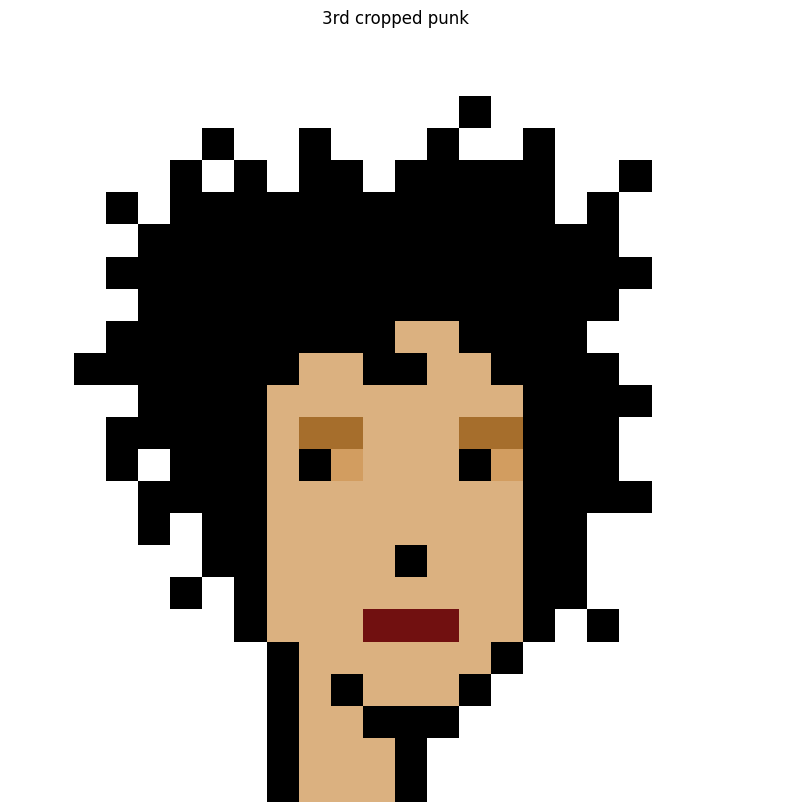

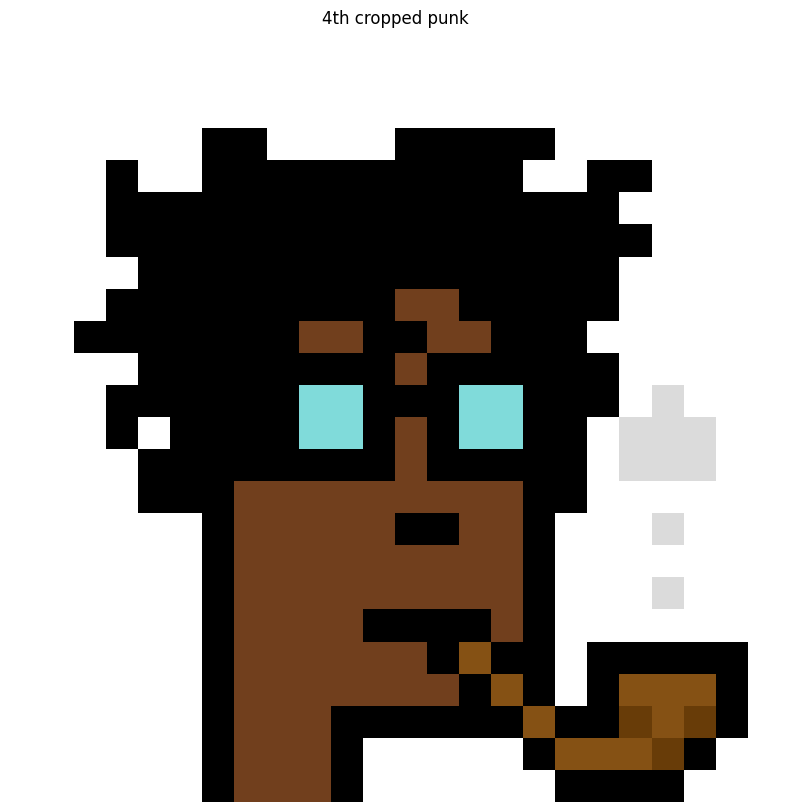

In [ ]:
punks = crop(np_img, Config.crop_size)
show(punks[0], title = "1st cropped punk")
show(punks[1], title = "2nd cropped punk")
show(punks[2], title = "3rd cropped punk")
show(punks[3], title = "4th cropped punk")

## Save croppped images

In [ ]:
# save to a folder
if not os.path.exists(Config.data_dir):
    path = os.path.join(Config.data_dir, 'cropped')
    os.makedirs(path)
    for i, punk in enumerate(punks):
        Image.fromarray(punk).save(os.path.join(path, f'{i:06}.png'))

## Data pipeline

### Transforms

For transforms, we won't be using any data augmentation because we want to produce samples as close to the original distribution as possible. We will only use `ToTensor()` to convert loaded `PIL.Image` to `torch.Tensor`, and then `Normalize()` to normalize all images to a range of `[-1, 1]` using means and standard deviations of `0.5` for each channel. The transformation is computed using the formula below:
$$ \text{normalized_img} = \frac{(\text{img} / 255) - 0.5}{0.5}$$

This way pixels that had the value `(255, 255, 255, 255)` will become `(1, 1, 1, 1)`, and pixels `(0, 0, 0, 0)` will become `(-1, -1, -1, -1)`.

### Dataset

To generate a dataset, we will be using the default `ImageFolder`. Usually, this class is used for image classification problems, so it expects subfolders with images of a given class, but in our class, we have only one class of images, so we will put all of our images in a folder `cropped` inside of `cryptopunk_data`. Also, `ImageFolder` expects 3 channel images, and to load 4 channel images we will pass our custom loading function `lambda x: Image.open(x)` as a `loader` parameter to `ImageFolder`.

### Dataloader

To get the data loader, we will pass our `image_dataset` to `DataLoader` and specify parameters using `Config`.

In [ ]:
# define transforms
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(Config.norm_mean, Config.norm_std)
])

# get dataset
img_dataset = ImageFolder(
    Config.data_dir,
    transform=img_transforms,
    loader=lambda x: Image.open(x)
)

# create dataloader
train_loader = DataLoader(
    img_dataset,
    Config.batch_size,
    shuffle=True,
    num_workers=Config.num_workers
)

## Visualize a batch of data

Next, we will define a function to visualize a batch of incoming data. To do so, we will need to convert images to a format readable by `matplotlib`.

In [ ]:
def visualize_batch(batch, title=None, save=None, mean=Config.norm_mean, std=Config.norm_std):
    # create grid
    grid = make_grid(batch, nrow=int(np.sqrt(len(batch))))
    # tensor -> array
    np_grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    np_grid = (np_grid * std + mean).clip(0, 1)

    # show or save figure
    plt.figure(figsize=(16, 12))
    plt.axis("off")
    plt.imshow(np_grid)
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
        plt.close()
    else:
        plt.show()
    return grid

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


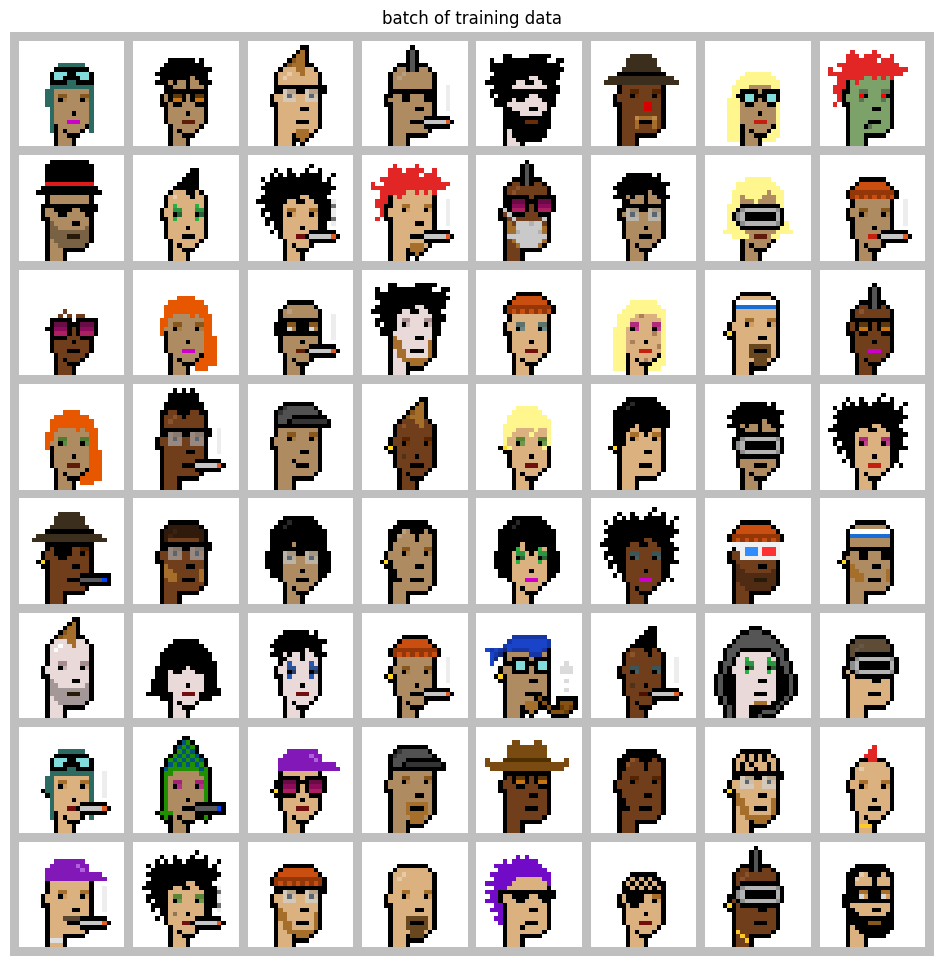

In [ ]:
batch, _ = next(train_loader.__iter__())
grid = visualize_batch(batch, title='batch of training data')

# 3 - Model

## Generator [[src](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)]

The generator, $G$, is designed to map the latent space vector ($z$) to data-space. Since our data are images, converting $z$ to data-space means ultimately creating a RGBA image with the same size as the training images (i.e. 4x24x24). In practice, this is accomplished through a series of strided two dimensional transpose convolutional layers, each paired with a 2d batch norm layer and a ReLU activation function. The output of the generator is fed through a tanh function to return it to the input data range of $[-1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. The diagram of the generator model is shown below:

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/generator.png">

 For the generator, we will implement three components:
* `GConvBlock` - main block of the generator that upscales the input using transpose convolutions
* `GInputBlock` - the first convolutional block of the generator with a slightly different config
* `GOutputBlock` - the final block of the generator with `Tanh` activation function

### Generator Convolutional block

In the Convolutional block, we will use the most common approach for upscaling the spatial dimension of the image — transpose convolutions. The downside of this method is a **checkerboard pattern** that emerges on the generated images when the convolutional window passes more times over some pixels than others. The best way to avoid this pattern is to choose `kernel_size` divisible by `stride`, but it is impossible in some cases because of the input and output size specifications. **Check out** [this article](https://distill.pub/2016/deconv-checkerboard/) that describes this artifact in depth.

**Excercise:** Implement the `__init__` function of the `GConvBlock`

**Directions:**
* It should contain `nn.ConvTranspose2d -> nn.BatchNorm2d -> nn.ReLU` joint together in `nn.Sequential`
* For `nn.ConvTranspose2d` indicate kernel size of **4** stride of **2**, and padding of **1** pixel; **don't** use bias.
* For `nn.ReLU` use `inplace=True`
* All other optional paramters should be default

In [ ]:
# VALIDATION_FIELD[cls] GConvBlock

class GConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(GConvBlock, self).__init__()
        ### START CODE HERE ### (≈15 lines of code)
        self.ConvBlock = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        ### END CODE HERE ###
    def forward(self, x):
        x = self.ConvBlock(x)
        return x

In [ ]:
x = torch.randn((1, 8,  12, 12))
GConv = GConvBlock(8, 4)
print('Output shape:', GConv(x).shape)

Output shape: torch.Size([1, 4, 24, 24])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 4, 24, 24]) </td>
</tr>
</table>

## Generator Input Block

`GInputBlock` is identical to `GConvBlock`, except for the following parameters of `nn.ConvTranspose2d`:
* kernel size is **3**
* stride is **1**
* padding is **0**

**Excercise:** implelemt `__init__` method of `GConvBlock` according to the specifications

In [ ]:
# VALIDATION_FIELD[cls] GInputBlock

class GInputBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(GInputBlock, self).__init__()
        ### START CODE HERE ### (≈15 lines of code)
        self.InputBlock = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )


        ### END CODE HERE ###
    def forward(self, x):
        x = self.InputBlock(x)
        return x

In [ ]:
x = torch.randn((1, 16,  1, 1))
GConv = GInputBlock(16, 8)
print('Output shape:', GConv(x).shape)

Output shape: torch.Size([1, 8, 3, 3])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 8, 3, 3]) </td>
</tr>
</table>

## Generator Output Block

`GOutputBlock` should have `nn.Sequential` that contains `nn.ConvTranspose2d` followed by `nn.Tanh` activation funciton. The specifications for the transpose convolutionas are the following:

* kernel size is **4**
* stride is **2**
* padding is **1**
* **no** bias

**Excercise:** Implement `GOutputBlock` using the specifications above.


In [ ]:
# VALIDATION_FIELD[cls] GOutputBlock

class GOutputBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(GOutputBlock, self).__init__()
        ### START CODE HERE ### (≈9 lines of code)
        self.OutputBlock = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        ### END CODE HERE ###

    def forward(self, x):
        x = self.OutputBlock(x)
        return x

In [ ]:
x = torch.randn((1, 8,  4, 4))
GConv = GOutputBlock(8, 3)
print('Output shape:', GConv(x).shape)

Output shape: torch.Size([1, 3, 8, 8])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 3, 8, 8]) </td>
</tr>
</table>

### Generator Class

Let's put everything together in the `Generator` class. It should contain `GInputBlock`, two `GConvBlock`, and one `GOutputBlock`. The progression of the input channels should be `nz -> ngf*4 -> ngf*2 -> ngf`

**Excercise:** Implement `__init__` and `forward` classes of the `Generator`.

In [ ]:
# VALIDATION_FIELD[cls] Generator

class Generator(torch.nn.Module):
    def __init__(self, nz=Config.nz, nc=Config.nc, ngf=Config.ngf):
        super(Generator, self).__init__()
        ### START CODE HERE ### (≈4 lines of code)
        self.input = GInputBlock(nz, ngf * 4)
        self.conv1 = GConvBlock(ngf * 4, ngf * 2)
        self.conv2 = GConvBlock(ngf * 2, ngf)
        self.out = GOutputBlock(ngf, nc)
        ### END CODE HERE ###

    def forward(self, x):   # x: [batch, 100, 1, 1]
        ### START CODE HERE ### (≈4 lines of code)
        x = self.input(x)   # x: [batch, 128, 3, 3]
        x = self.conv1(x)   # x: [batch, 64, 6, 6]
        x = self.conv2(x)   # x: [batch, 32, 12, 12]
        x = self.out(x)   # x: [batch, 4, 24, 24]
        ### END CODE HERE ###
        return x

In [ ]:
x = torch.randn(1, 100, 1, 1)
print('output shape:', Generator()(x).shape)

output shape: torch.Size([1, 4, 24, 24])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 4, 24, 24]) </td>
</tr>
</table>

## Discriminator

In the **DCGAN**, the discriminator, $D$, is a convolutional neural network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). In the **WGAN**, however, the discriminator outputs a real value, critic, which is not restricted by the sigmoid activation function at the end. During training, the discriminator will try to maximize the difference between the fake and real images. At the same time, the generator will attempt to maximize the output of the discriminator for the fake images. Since the outputs of the discriminator are unbounded, the training can progress without vanishing gradient problems, which helps achieve a better quality of generated images.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/discrimnator.png">

The structure of the discriminator is very similar to the generator, but instead of transpose convolutions, it uses regular Conv2d layers, and instead of the ReLU activation function, it uses LeakyReLU. $D$ takes a 4x24x24 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final critic. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also, batch norm and LeakyReLU functions promote healthy gradient flow, which is critical for the learning process of both $G$ and $D$.

For the discriminator, we will implement three main components:
* `DConvBlock` - main block of the discriminator that downscales the input using convolutions
* `DInputBlock` - the first convolutional block of the discriminator with a slightly different config
* `DOutputBlock` - the final convolutional block of the discrimnator with **no** activation function

### DConvBlock

`DConvBlock` is essentially analogous to a `GConvBlock` with a few small modifications.

* It is a Sequential block that contains: `nn.Conv2d -> nn.BatchNorm2d -> nn.LeakyReLU`
* `nn.Conv2d` has the following specifications:
    * kernel size is **4**
    * stride is **2**
    * padding us **1**
    * there is **no** bias
* `nn.LeakyReLU` should have the negative slope of **0.2** and `inplace=True`

**Excercise:** Implement DConvBlock using the specifications above.

In [ ]:
# VALIDATION_FIELD[cls] DConvBlock

class DConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DConvBlock, self).__init__()
        ### START CODE HERE ### (≈16 lines of code)
        self.ConvBlock = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )

        ### END CODE HERE ###

    def forward(self, x):
        x = self.ConvBlock(x)
        return x

In [ ]:
x = torch.randn((1, 8,  4, 4))
DConv = DConvBlock(8, 3)
print('Output shape:', DConv(x).shape)

Output shape: torch.Size([1, 3, 2, 2])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 3, 2, 2]) </td>
</tr>
</table>

### DInputBlock

`DInputBlock` should have the following specifications:
* it is a sequential block that has `Conv2d` followed by `LeakyReLU`
* `Conv2d` should have:
    * kernel size is **4**
    * stride is **2**
    * padding is **1**
    * there is **no** bias
* `LeakyReLU` should have:
    * `negative_slope` is **0.2**
    * set `inplace = True`

In [ ]:
# VALIDATION_FIELD[cls] DInputBlock

class DInputBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DInputBlock, self).__init__()
        ### START CODE HERE ### (≈16 lines of code)
        self.InputBlock = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        ### END CODE HERE ###

    def forward(self, x):
        x = self.InputBlock(x)
        return x

In [ ]:
x = torch.randn((1, 4,  32, 32))
DConv = DInputBlock(4, 6)
print('Output shape:', DConv(x).shape)

Output shape: torch.Size([1, 6, 16, 16])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 6, 16, 16]) </td>
</tr>
</table>

### DOutputBlock

Last but not least, let's implement `DOutputBlock` that has a single `Conv2d` block with the kernel size of **3**, stride of **1**, zero padding, and **no** bias.

In [ ]:
# VALIDATION_FIELD[cls] DOutputBlock

class DOutputBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DOutputBlock, self).__init__()
        ### START CODE HERE ### (≈ 8 lines of code)
        self.OutputBlock = nn.Conv2d(
            in_ch, out_ch, kernel_size=3, stride=1, padding=0, bias=False
        )
        ### END CODE HERE ###

    def forward(self, x):
        x = self.OutputBlock(x)
        return x

In [ ]:
x = torch.randn((1, 4,  3, 3))
DConv = DOutputBlock(4, 1)
print('Output shape:', DConv(x).shape)

Output shape: torch.Size([1, 1, 1, 1])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 1, 1, 1]) </td>
</tr>
</table>

### Discrimnator Class

Let's put everything together in the `Discrimnator` class. It should contain `DInputBlock`, two `DConvBlock`, and one `DOutputBlock`. The progression of the input channels should be `nc -> ndf -> ndf*2 -> ndf*4`

**Excercise:** Implement `__init__` and `forward` classes of the `Discrimnator`.

In [ ]:
# VALIDATION_FIELD[cls] Discriminator

class Discriminator(nn.Module):
    def __init__(self, nc=Config.nc, ndf=Config.ndf):
        super(Discriminator, self).__init__()
        ### START CODE HERE ### (≈4 lines of code)
        self.input = DConvBlock(nc, ndf)
        self.conv1 = DConvBlock(ndf, ndf * 2)
        self.conv2 = DConvBlock(ndf * 2, ndf * 4)
        self.output = DOutputBlock(ndf * 4, 1)
        ### END CODE HERE ###

    def forward(self, x):   # x: [batch, 4, 24, 24]
        ### START CODE HERE ### (≈4 lines of code)
        x = self.input(x)   # x: [batch, 64, 12, 12]
        x =  self.conv1(x)  # x: [batch, 128, 6, 6]
        x =  self.conv2(x)  # x: [batch, 256, 3, 3]
        x =  self.output(x)  # x: [batch, 1, 1, 1]
        ### END CODE HERE ###
        x = x.view(-1, 1)   # x: [batch, 1]
        return x

In [ ]:
D = Discriminator()
input = torch.randn(1, 4, 24, 24)
print('Output shape:', D(input).shape)

Output shape: torch.Size([1, 1])


**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 1]) </td>
</tr>
</table>

### Custom Weights Initialization [[src](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#weight-initialization)]

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [ ]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, torch.nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 4 - Training the model

Training the GAN model is always a complex task. In a way, training GANs is somewhat of an art form, as incorrect hyperparameter settings lead to mode collapse with little explanation of what went wrong.

## Classic GAN [[src](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#training)]

For the classic GAN, the objective function is defined as follows:

$$ \min_G \max_D L(G, D) = \mathbb{E}_{x\in p_{data}(X)}[log(D(x))]+\mathbb{E}_{z\in p_z(z)}[log(1−D(G(z)))]$$

**In theory** it means that:
* For the discriminator, $D$:
    * We want to maximize the probability of $D$ classifying real images as 1
    * We want to maximize the probability of $D$ classifying fake images as 0
* For the generator, $G$:
    * We want to minimize the probability of $D$ classifying fake images as 0. In other words, for $G$ we want $D$ to misclassify the fake images.

**In practice**, however, it is much simpler to split up the objective function into two parts and perform optimization separately for $G$ and for $D$.

### 1. Train discriminator for $k$ steps

We want to maximize $\log(D(x)) + \log(1-D(G(z)))$. Due to the separate mini-batch suggestion from [ganhacks](https://github.com/soumith/ganhacks), we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through $D$, calculate the loss $\log(D(x))$, then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through $D$, calculate the loss $\log(1-D(G(z)))$, and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the discriminator’s optimizer.

**Implementation hint:** maximizing $\log(D(x))$ is the same things as minimizing `BCELoss` between `D(x)` and a tensor of ones. Similarly, maximizing $\log(1-D(G(z)))$ is the same as minimizing `BCELoss` between `D(G(z))` and a tensor of zeros.

### 2. Train generator for one step

As stated in the original paper, we want to train the generator by minimizing $\log(1-D(G(z)))$ in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize $log(D(G(z)))$.

**Implementation hint:** maximizing $log(D(G(z)))$ can be achieved through minimizing the `BCELoss` between `D(G(z))` and a tensor of ones.

## Wasserstein GAN

In Wasserstein GAN, the loss function is slightly different:

$$ \min_G \max_D L(G, D) = \mathbb{E}_{x\in p_{data}(X)}[D(x)]-\mathbb{E}_{z\in p_z(z)}[D(G(z))]$$

As mentioned before, the main modification of Wasserstein GAN is that the discriminator in this setting outputs a real value $\in(-\infty, +\infty)$, called critic, that signifies how real is the image. The goal of the discriminator is to maximize the difference between the expected value of the critic for real and for fake images, while the discriminator attempts to minimize that distance. In practice, we can split the objective function into two parts:

### 1. Train discriminator for $k$ steps

We want to maximize $\mathbb{E}_{x\in p_{data}(X)}[D(x)]-\mathbb{E}_{z\in p_z(z)}[D(G(z))]$, which is equivalent to minimizing $\mathbb{E}_{z\in p_z(z)}[D(G(z))]-\mathbb{E}_{x\in p_{data}(X)}[D(x)]$. To implement this, we will simply calculate the mean value of the critic for the batch of fake images and subtract it from the mean value of the critic for the batch of real images.

### 2. Train generator for one step

Our goal is to minimize $\mathbb{E}_{x\in p_{data}(X)}[D(x)]-\mathbb{E}_{z\in p_z(z)}[D(G(z))]$. Since, only the second part of the equation is dependent on $G$, we can rephrase our optimization objective as: $$\min_{G}-\mathbb{E}_{z\in p_z(z)}[D(G(z))]$$

To implement this, we will simply compute the negative of the mean value for the critic for the generated (fake) images and call `backward`.


## Training discriminator

Here, you will have a chance to implement the function for training the discriminator. If the `criterion` is set to None, use the Wasserstein loss function for training. Otherwise, `criterion` will be set to `BCELoss` for the classical GAN loss function.

**Excercise:** Implement `train_discriminator` function.

**Steps**
* prepeare data
    1. generate noise vector (using `torch.randn`)
    2. create a tensor of ones for `real_labels`
    3. create a tensor of zeros for `fake_labels`
* forward pass
    1. generate fake images
    2. compute the output value of the discriminator for `real_images` and for `fake_images`
* compute the loss
    * if criterion is **None** we are in the Wasserstein setting
        1. calculate the loss using
$\mathbb{E}_{z\in p_z(z)}[D(G(z))]-\mathbb{E}_{x\in p_{data}(X)}[D(x)]$
    * otherwise we will use classical GAN loss
        1. pass the outputs of the discrimnator through a sigmoid activation function using `torch.sigmoid`
        2. compute the `BCELoss` between the `real_labels` and `real_outputs` from the discrimnator.
        3. compute the `BCELoss` between the `fake_labels` and `fake_outputs` from the discrimnator.
        4. add two losses into one `loss` variable.
* perform optimization
    1. zero the gradients
    2. backward pass
    3. step of the discrimnator's optimizer.

In [ ]:
def train_discriminator(netD, netG, optimizerD, real_images,
                       k_steps=Config.train_D_steps,
                       nz=Config.nz,
                       criterion=None,
                       device=Config.device):

    overall_loss = 0
    # get current batch size using inputs
    batch_size = real_images.size(0)

    # train discrimnator for k steps
    for k in range(k_steps):

        # get noize of shape [batch, nz, 1, 1]
        z = torch.randn(batch_size, nz, 1, 1, device=device)

        # get labels of shape [batch, 1]
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # forward pass
        fake_images = netG(z)
        real_outputs = netD(real_images)
        fake_outputs = netD(fake_images)

        # calculate the loss
        if criterion is None:
            # WGAN setting: minimize E[D(G(z))] - E[D(x)]
            loss = fake_outputs.mean() - real_outputs.mean()
        else:
            # Classic GAN loss: minimize - E[log(D(x))] - E[log(1 - D(G(z)))]
            # pass outputs through sigmoid
            real_outputs = torch.sigmoid(real_outputs)
            fake_outputs = torch.sigmoid(fake_outputs)
            # compute parts of the loss using criterion
            d_x = criterion(real_outputs, real_labels)
            d_g_z = criterion(fake_outputs, fake_labels)
            # find the total loss
            loss = d_x + d_g_z

        # optimzie (≈3 lines of code)
        optimizerD.zero_grad()
        loss.backward()
        optimizerD.step()

        overall_loss += loss.item()

    return overall_loss

In [ ]:
set_seed(Config.seed)
loader = train_loader.__iter__()
netG = Generator().to(Config.device)
netD = Discriminator().to(Config.device)
netD.apply(weights_init)
netG.apply(weights_init)

# test wasserstein loss
real_images, _ = next(loader)
real_images = real_images.to(Config.device)
optimizerD = optim.RMSprop(netD.parameters(), lr=Config.learning_rate)
wasserstein_loss = train_discriminator(netD, netG, optimizerD, real_images, criterion=None)

# test classical loss
real_images, _ = next(loader)
real_images = real_images.to(Config.device)
optimizerD = optim.Adam(netD.parameters(), lr=Config.learning_rate)
criterion = nn.BCELoss()
classical_loss = train_discriminator(netD, netG, optimizerD, real_images, criterion=criterion)

print('wasserstein loss:', wasserstein_loss)
print('classical loss:', classical_loss)

wasserstein loss: -43.74768203496933
classical loss: 0.002073566836770624


**Expected output:**
<table>
<tr>
    <td> <b> wasserstein loss </b> </td>
    <td> 0.5999088883399963 </td>
</tr>
<tr>
    <td> <b> classical loss </b> </td>
    <td> 0.214063823223114 </td>
</tr>
</table>

## Training generator

**Excercise:** Implement `train_generator` function

**Steps:**

* prepare data
    1. generate noize vector
    2. create a tensor of ones for `real_labels`
* forward pass
    1. generate the output of the discriminator for the generated images
* calculate the loss
    * if the criterion is **None** we are in the Wasserstein setting
        1. compute the loss using the formula $-\mathbb{E}_{z\in p_z(z)}[D(G(z))]$
    * otherwise, we will use classical GAN loss:
        1. pass the outputs through a sigmoid activation function
        2. compute the `BCELoss` between the outputs from the discriminator and `real_labels`
* optimize
    1. zero the gradients
    2. call backward
    3. perform optimization step on the generator's optimizer

In [ ]:
# VALIDATION_FIELD[func] train_generator

def train_generator(netD, netG, optimizerG,
                    batch_size=Config.batch_size,
                    nz=Config.nz,
                    criterion=None,
                    device=Config.device):

    ### START CODE HERE ### (≈11 lines of code)
    # get noize of shape [batch, nz, 1, 1]
    z =

    # get real labels of shape [batch, 1]
    real_labels =

    # forward pass (≈1-2 lines of code)
    output =

    # calculate the loss
    if criterion is None:
        # WGAN setting: minimize -E[D(G(z))]
        loss =
    else:
        # Classical GAN loss: minimize E[log(1 - D(G(z)))]
        # pass through sigmoid
        output =
        # calculate the loss using criterion
        loss =

    # optimize (≈3 lines of code)

    ### END CODE HERE ###

    return loss.item()

In [ ]:
set_seed(Config.seed)
netG = Generator().to(Config.device)
netD = Discriminator().to(Config.device)
netD.apply(weights_init)
netG.apply(weights_init)

# test wasserstein loss
optimizerG = optim.RMSprop(netG.parameters(), lr=Config.learning_rate)
wasserstein_loss = train_generator(netD, netG, optimizerG, criterion=None)

# test classical loss
optimizerG = optim.Adam(netG.parameters(), lr=Config.learning_rate)
criterion = nn.BCELoss()
classical_loss = train_generator(netD, netG, optimizerG, criterion=criterion)

print('wasserstein loss:', wasserstein_loss)
print('classical loss:', classical_loss)

**Expected output:**
<table>
<tr>
    <td> <b> wasserstein loss </b> </td>
    <td> -0.3245828449726105 </td>
</tr>
<tr>
    <td> <b> classical loss </b> </td>
    <td> 0.1470302790403366 </td>
</tr>
</table>

## Overall train

Finally, let's put everything together in one training function. Please **note** that we also **clip** the parameters of the Discriminator at every step of the optimization to ensure that our critic function is **one Lipschitz continuous** — a crucial step to ensure that Wasserstein's loss is valid.

In [ ]:
def train(
    netG,
    netD,
    optimizerD,
    optimizerG,
    train_loader,
    criterion=None,
    nz=Config.nz,
    batch_size=Config.batch_size,
    num_epochs=Config.epochs,
    save_every=Config.save_every,
    clip=Config.clip_value,
    k_steps=Config.train_D_steps,
    logdir=Config.logdir,
    device=Config.device
    ):

    if not os.path.exists(logdir):
        os.makedirs(logdir)
    tb_writer = SummaryWriter(log_dir=logdir)
    fixed_noise = torch.randn(batch_size, nz, 1, 1).to(device)

    for e in range(num_epochs):
        d_loss = 0
        g_loss = 0
        for i, (imgs, _) in enumerate(train_loader):
            # train discrimnator for k steps
            imgs = imgs.to(device)
            loss = train_discriminator(netD, netG, optimizerD, imgs, k_steps, nz, criterion, device)
            d_loss += loss * imgs.shape[0]

            # clip params of Discrimnator
            if criterion is None:
                for p in netD.parameters():
                    p.data.clamp_(-clip, clip)

            # train generator
            loss = train_generator(netD, netG, optimizerG, batch_size, nz, criterion, device)
            g_loss += loss * imgs.shape[0]

        # Log & save
        if e % save_every == 0:

            # print losses
            d_loss = d_loss / len(train_loader.sampler) / k_steps
            g_loss = g_loss / len(train_loader.sampler)
            print(f'Epoch: {e}, G Loss:{g_loss:.6f}, D Loss:{d_loss:.6f}')

            # make grid of examples
            with torch.no_grad():
                netG.eval() # we don't have to call eval because there are no dropouts
                generated = netG(fixed_noise).cpu()
                netG.train()

            # round up transperency layer
            grid = visualize_batch(
                generated,
                title='Generated images',
                save=os.path.join(logdir, f'generated_{e}.png')
            )

            # Tensorboards Logging
            tb_writer.add_scalar('DCGAN/D Loss', d_loss, e)
            tb_writer.add_scalar('DCGAN/G Loss', g_loss, e)
            tb_writer.add_image('DCGAN/Output', grid, e)

            # Save checkpoints
            torch.save(netG.state_dict(), os.path.join(logdir, 'netG.pt'))
            torch.save(netD.state_dict(), os.path.join(logdir, 'netD.pt'))

            # Save optimizers
            torch.save(optimizerG.state_dict(), os.path.join(logdir, 'optG.pt'))
            torch.save(optimizerD.state_dict(), os.path.join(logdir, 'optD.pt'))

## TensorBoard

In [ ]:
# to start TensorBoard run the following command
%load_ext tensorboard
%tensorboard --logdir logs

## Run

In [ ]:
set_seed(Config.seed)
# Initialize Models
netG = Generator().to(Config.device)
netD = Discriminator().to(Config.device)

# Initialize weights
netD.apply(weights_init)
netG.apply(weights_init)

# Get optimizers
if Config.earthmover_loss:
    optimizerD = optim.RMSprop(netD.parameters(), lr=Config.learning_rate)
    optimizerG = optim.RMSprop(netG.parameters(), lr=Config.learning_rate)
else:
    optimizerD = optim.Adam(netD.parameters(), lr=Config.learning_rate)
    optimizerG = optim.Adam(netG.parameters(), lr=Config.learning_rate)

# get criterion
criterion = nn.BCELoss() if not Config.earthmover_loss else None

# run training
train(netG, netD, optimizerD, optimizerG, train_loader, criterion)

**Expected output:**
```
Epoch: 0, G Loss:-0.011979, D Loss:-0.003951
Epoch: 5, G Loss:0.135263, D Loss:-0.067713
Epoch: 10, G Loss:0.122480, D Loss:-0.058385
Epoch: 15, G Loss:0.112281, D Loss:-0.052588
Epoch: 20, G Loss:0.106296, D Loss:-0.050492
```

# 5 - Generate some art

Finally, let's have some fun! Use a random `seed` number to generate new CryptoPunks.

In [ ]:
def generate_dudes(seed, nz=Config.nz, device=Config.device, batch_size=Config.batch_size):
    if seed is not None:
        torch.manual_seed(seed)
    with torch.no_grad():
        z = torch.randn(batch_size, nz, 1, 1).to(device)
        netG.eval() # we don't have to call eval because there are no dropouts
        generated = netG(z).cpu()
        # round up alpha channel
        generated[:,3] = generated[:,3].round()
        grid = visualize_batch(generated, title='Generated images')

In [ ]:
generate_dudes(228)